## Install Dependencies

In [1]:
seed_value = 123
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

In [2]:
# Connecting to Google drive in order to store the weights of the agents HDF5 files.
from google.colab import drive

drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [3]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 5.0 MB/s 
     |████████████████████████████████| 106 kB 51.6 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=605bda8bb26b7942dd5648255ee38e40b70b1fdd5e97aefbee8ea5a6d47eeec3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [4]:
!pip uninstall matplotlib --yes
!pip install matplotlib==3.1.3 

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.0.0 requires matplotlib<4.0.0,>=3.2.2, but you have matplotlib 3.1.3 which is incompatible.


In [5]:
pip install tensorflow-determinism

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9158 sha256=19ea49c3fa23edf72a6a5e6f3d14a69f3c088934f80ba79de00721662a9d201e
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


## Importing Libraries

In [6]:
# seed_value = 123
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import math
import zipfile
import wfdb as wf
import pickle
import sys
import datetime
import cv2
import random
import random as python_random
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [8]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
   os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [9]:
np.random.seed(seed_value)
vec = np.random.randint(1, 10)
print(vec)
random.seed(123)
print(random.random())
tf.random.set_seed(123)
print(tf.random.uniform([1])) 

3
0.052363598850944326
tf.Tensor([0.12615311], shape=(1,), dtype=float32)


## Extracting Data

In [10]:
module = os.path.abspath('/content/gdrive/MyDrive/WESAD/')
if module not in sys.path:
    sys.path.append(module)
from DataManager import DataManager

## Data Preprocessing

In [11]:
# config
debug = False;

In [12]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [13]:
test_subject = [9]
rest_subjects = [2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17]

In [14]:
def generateData(subject_ids):
    data = DataManager()
    all_subject_data = np.array([]);
    all_subject_labels = np.array([]);

#     subject_ids = [2, 3]

    for subject_id in subject_ids:
        if(debug): print("Processing subject id: ", subject_id);
        subject = data.load(subject_id)


        if(debug):
            print('baseline: ', subject[0], '\nstress: ', subject[1], '\namusement: ', subject[2], '\nbase_label: ', subject[3], '\nstress_label: ', subject[4], '\namuse_label: ', subject[5])

        ecg_base = subject[0]
        ecg_stress = subject[1]
        ecg_amusement = subject[2]

        base_label = subject[3]
        stress_label = subject[4]
        amuse_label = subject[5]

        ecg_base_T = ecg_base.T
        ecg_stress_T = ecg_stress.T
        ecg_amusement_T = ecg_amusement.T

        ecg_base_data = ecg_base_T[0]
        ecg_stress_data = ecg_stress_T[0]
        ecg_amusement_data = ecg_amusement_T[0]

        ecg_base_label =  base_label.T
        ecg_stress_label  = stress_label.T
        ecg_amusement_label  = amuse_label.T

        if(debug):
            print('ecg_base_data:', ecg_base_data)
            print('ecg_stress_data:', ecg_stress_data)
            print('ecg_amusement_data:', ecg_amusement_data)

            print('ecg_base_label:', ecg_base_label)
            print('ecg_stress_label:', ecg_stress_label)
            print('ecg_amusement_label:', ecg_amusement_label)


        base_secs = len(ecg_base_data) // 700 # Number of seconds in signal X
        base_samps = int(base_secs * 256 )    # Number of samples to downsample
        base_down = signal.resample(ecg_base_data, base_samps)


        stress_secs = len(ecg_stress_data) // 700 # Number of seconds in signal X
        stress_samps = int(stress_secs * 256 )    # Number of samples to downsample
        stress_down = signal.resample(ecg_stress_data, stress_samps)


        amuse_secs = len(ecg_amusement_data) // 700 # Number of seconds in signal X
        amuse_samps = int(amuse_secs * 256 )    # Number of samples to downsample
        amuse_down = signal.resample(ecg_amusement_data, amuse_samps)

    #     heart_beat_base = np.array_split(base_down, 256)
    #     heart_beat_stress = np.array_split(stress_down, 256)
    #     heart_beat_amuse = np.array_split(amuse_down, 256)

        window_size = 256
        window_shift = 256

        heart_beat_base = []
        for i in range(0,len(base_down) - window_size,window_shift):
            heart_beat_base.append(base_down[i:window_size + i])
        heart_beat_base.pop()
    #     heart_beat_base = np.array(list(heart_beat_base[:]), dtype=float)

        heart_beat_stress = []
        for i in range(0,len(stress_down) - window_size,window_shift):
            heart_beat_stress.append(stress_down[i:window_size + i])
        heart_beat_stress.pop()
    #     heart_beat_stress = np.array(list(heart_beat_stress[:]), dtype=float)

        heart_beat_amuse = []
        for i in range(0,len(amuse_down) - window_size,window_shift):
            heart_beat_amuse.append(amuse_down[i:window_size + i])
        heart_beat_amuse.pop()
    #     heart_beat_amuse = np.array(list(heart_beat_amuse[:]), dtype=float)


        for idx, idxval in enumerate(heart_beat_base):
            heart_beat_base[idx] = (heart_beat_base[idx] - heart_beat_base[idx].min()) / heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_base[idx] = np.append(heart_beat_base[idx], 0.0) #Baseline = 0

        for idx, idxval in enumerate(heart_beat_stress):
            heart_beat_stress[idx] = (heart_beat_stress[idx] - heart_beat_stress[idx].min()) / heart_beat_stress[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_stress[idx] = np.append(heart_beat_stress[idx], 1.0) #Stress = 1    

        for idx, idxval in enumerate(heart_beat_amuse):
            heart_beat_amuse[idx] = (heart_beat_amuse[idx] - heart_beat_amuse[idx].min()) / heart_beat_amuse[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_amuse[idx] = np.append(heart_beat_amuse[idx], 2.0) #Amusement = 2

    #     print("heart_beat_base:", len(heart_beat_base[0]), len(heart_beat_base[-2]), len(heart_beat_base[-1]))
    #     print("heart_beat_stress:", len(heart_beat_stress[0]), len(heart_beat_stress[-1]))
    #     print("heart_beat_amuse:", len(heart_beat_amuse[0]), len(heart_beat_amuse[-1]))

        heart_beat_all = np.concatenate((heart_beat_base, heart_beat_stress, heart_beat_amuse), axis=0)
        subject_data = np.array(list(heart_beat_all[:]), dtype=float)


        if(all_subject_data.size == 0):
            all_subject_data = subject_data
        else:
            if(subject_data.size != 0):
                all_subject_data = np.concatenate((all_subject_data, subject_data), axis=0)

        print("New data shape", subject_data.shape, "Total Shape: ", all_subject_data.shape)
        
    #SMOTE to balance the data
    df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
    df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

    smote = SMOTE(sampling_strategy='not majority')
    X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
    
    return X_sm, y_sm

## Data Generation - Train

In [15]:
train_data, train_labels = generateData(rest_subjects)

Loading data for S2
New data shape (2115, 257) Total Shape:  (2115, 257)
Loading data for S3
New data shape (2149, 257) Total Shape:  (4264, 257)
Loading data for S4
New data shape (2159, 257) Total Shape:  (6423, 257)
Loading data for S5
New data shape (2211, 257) Total Shape:  (8634, 257)
Loading data for S6
New data shape (2196, 257) Total Shape:  (10830, 257)
Loading data for S7
New data shape (2192, 257) Total Shape:  (13022, 257)
Loading data for S8
New data shape (2202, 257) Total Shape:  (15224, 257)
Loading data for S10
New data shape (2271, 257) Total Shape:  (17495, 257)
Loading data for S11
New data shape (2222, 257) Total Shape:  (19717, 257)
Loading data for S13
New data shape (2220, 257) Total Shape:  (21937, 257)
Loading data for S14
New data shape (2221, 257) Total Shape:  (24158, 257)
Loading data for S15
New data shape (2227, 257) Total Shape:  (26385, 257)
Loading data for S16
New data shape (2215, 257) Total Shape:  (28600, 257)
Loading data for S17
New data shape 

In [16]:
train_labels.value_counts()

0.0    16403
1.0    16403
2.0    16403
dtype: int64

In [17]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train data shape: (49209, 256)
Train labels shape: (49209, 1)
Dimension: 2


In [18]:
train_labels = pd.DataFrame(train_labels).to_numpy()
train_labels = train_labels.reshape(-1)

In [19]:
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train labels shape: (49209,)
Dimension: 1


## Train and Validation data split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.3, random_state=42)

In [21]:
#Reshape train and validation data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

In [22]:
print('size of X_train:', X_train.shape)
print('size of X_val:', X_val.shape)

print('size of y_train:', y_train.shape)
print('size of y_val:', y_val.shape)

print('Train:', Counter(y_train), '\nVal:', Counter(y_val))

size of X_train: (34446, 256, 1)
size of X_val: (14763, 256, 1)
size of y_train: (34446,)
size of y_val: (14763,)
Train: Counter({1.0: 11496, 0.0: 11482, 2.0: 11468}) 
Val: Counter({2.0: 4935, 0.0: 4921, 1.0: 4907})


## Data Generation - Test

In [23]:
test_data, test_labels = generateData(test_subject)

Loading data for S9
New data shape (2191, 257) Total Shape:  (2191, 257)


In [24]:
test_labels.value_counts()

0.0    1178
1.0    1178
2.0    1178
dtype: int64

In [25]:
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Dimension:", test_labels.ndim)

Test data shape: (3534, 256)
Test labels shape: (3534, 1)
Dimension: 2


In [26]:
test_labels = pd.DataFrame(test_labels).to_numpy()
y_test = test_labels.reshape(-1)

In [27]:
print("Test labels shape:", y_test.shape)
print("Dimension:", y_test.ndim)

Test labels shape: (3534,)
Dimension: 1


In [28]:
#Reshape test data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_test = np.array(test_data).reshape(test_data.shape[0], test_data.shape[1], 1)

In [29]:
print('size of X_test:', X_test.shape)
print('size of y_test:', y_test.shape)

print('Test:', Counter(y_test))

size of X_test: (3534, 256, 1)
size of y_test: (3534,)
Test: Counter({0.0: 1178, 1.0: 1178, 2.0: 1178})


In [30]:
# df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
# df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

# smote = SMOTE(sampling_strategy='not majority')
# X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
# y_sm.value_counts()

In [31]:
# Reshape train and test data to (n_samples, 256, 1), where each sample is of size (256, 1)
# X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
# X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

## 1D CNN Model Architecture

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, MaxPool1D, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [33]:
reset_random_seeds()
initializer = tf.keras.initializers.HeUniform()
cnn_model = tf.keras.models.Sequential()
cnn_model.add(Input(shape = (X_train.shape[1],1)))
cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', kernel_initializer=initializer) )
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(4,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128, kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(Dense(units = 3, activation='softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 5)            30        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 10)           260       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 64, 10)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 10)            410       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 32, 10)           0

In [34]:
epochs=50
batch_size = 32

In [35]:
def step_decay(epoch):
  initial_lrate = 0.005
  drop = 0.6
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [36]:
# class LossHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#        self.losses = []
#        self.lr = []
 
#     def on_epoch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.lr.append(step_decay(len(self.losses)))

In [37]:
# loss_history = LossHistory()
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [loss_history, lrate]

In [38]:
opt = tf.keras.optimizers.SGD( learning_rate=0.0, momentum=0.6, nesterov=False)

cnn_model.compile(optimizer= opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = cnn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=2)

Epoch 1/50
1077/1077 - 16s - loss: 1.8112 - accuracy: 0.3766 - val_loss: 1.7203 - val_accuracy: 0.4261 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 2/50
1077/1077 - 5s - loss: 1.6281 - accuracy: 0.4466 - val_loss: 1.5386 - val_accuracy: 0.4774 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 3/50
1077/1077 - 5s - loss: 1.4634 - accuracy: 0.4799 - val_loss: 1.3946 - val_accuracy: 0.4854 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 4/50
1077/1077 - 5s - loss: 1.3495 - accuracy: 0.4920 - val_loss: 1.3000 - val_accuracy: 0.4966 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 5/50
1077/1077 - 5s - loss: 1.2668 - accuracy: 0.4970 - val_loss: 1.2695 - val_accuracy: 0.4507 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 6/50
1077/1077 - 5s - loss: 1.2008 - accuracy: 0.5026 - val_loss: 1.2347 - val_accuracy: 0.4845 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 7/50
1077/1077 - 5s - loss: 1.1502 - accuracy: 0.5081 - val_loss: 1.1791 - val_accuracy: 0.4540 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 8/50
1077/1077 - 5s - loss: 1.10

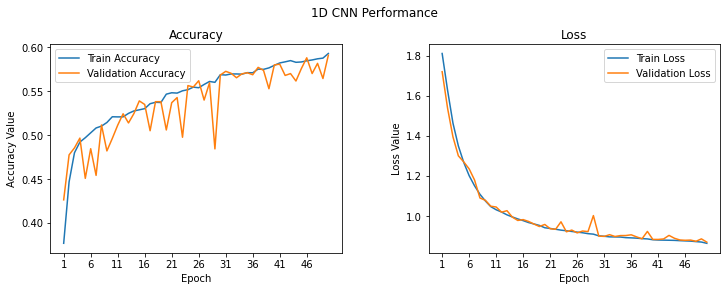

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [41]:
cnn_model.evaluate(X_test, y_test)

111/111 [==============================] - 0s 3ms/step - loss: 1.3690 - accuracy: 0.3149


[1.3690308332443237, 0.31494057178497314]

In [42]:
y_pred = cnn_model.predict(X_test)

111/111 [==============================] - 0s 2ms/step
